In [1]:
# connecting drive to colab notebook
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# installing requirements
!pip install imageio==2.19.3
!pip install opencv-python==4.6.0.66
!pip install tensorboardX==2.2
!pip install einops==0.4.1
!pip install scikit-learn==1.1.1
!pip install matplotlib==3.5.1
!pip install protobuf==3.20.0
!pip install fire==0.4.0
!pip install moviepy==1.0.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement scikit-learn==1.1.1 (from versions: 0.9, 0.10, 0.11, 0.12, 0.12.1, 0.13, 0.13.1, 0.14, 0.14.1, 0.15.0b1, 0.15.0b2, 0.15.0, 0.15.1, 0.15.2, 0.16b1, 0.16.0, 0.16.1, 0.17b1, 0.17, 0.17.1, 0.18, 0.18.1, 0.18.2, 0.19b2, 0.19.0, 0.19.1, 0.19.2, 0.20rc1, 0.20.0, 0.20.1, 0.20.2, 0.20.3, 0.20.4, 0.21rc2, 0.21.0, 0.21.1, 0.21.2, 0.21.3, 0.22rc2.post1, 0.22rc3, 0.22, 0.22.1, 0.22.2, 0.22.2.post1, 0.23.0rc1, 0.23.0, 0.23.1, 0.23.2, 0.24.dev0, 0.24.0r

In [3]:
import sys
sys.path.append('/content/drive/My Drive/drive_folder/pips/')
import time
import numpy as np
import io
import os
from PIL import Image
import cv2
import saverloader
import imageio as imageio
from nets.pips import Pips
import utils.improc
import random
import glob
from utils.basic import print_, print_stats
import torch
from tensorboardX import SummaryWriter
import torch.nn.functional as F
import matplotlib.pyplot as plt

# save numpy array as npz file
from numpy import asarray
from numpy import savez_compressed

In [4]:
def create_model(model_weights):
  model = Pips(stride=4).cuda()
  parameters = list(model.parameters())
  _ = saverloader.load(model_weights, model)
  global_step = 0
  model.eval()
  return model

In [64]:
# random.seed(125)
# np.random.seed(125)

def run_model(model, rgbs, N):
    rgbs = rgbs.cuda().float() # B, S, C, H, W

    B, S, C, H, W = rgbs.shape
    rgbs_ = rgbs.reshape(B*S, C, H, W)
    H_, W_ = 360, 640
    rgbs_ = F.interpolate(rgbs_, (H_, W_), mode='bilinear')
    H, W = H_, W_
    rgbs = rgbs_.reshape(B, S, C, H, W)

    # pick N points to track; we'll use a uniform grid
    N_ = np.sqrt(N).round().astype(np.int32)
    grid_y, grid_x = utils.basic.meshgrid2d(B, N_, N_, stack=False, norm=False, device='cuda')
    grid_y = 8 + grid_y.reshape(B, -1)/float(N_-1) * (H-16)
    grid_x = 8 + grid_x.reshape(B, -1)/float(N_-1) * (W-16)
    xy = torch.stack([grid_x, grid_y], dim=-1) # B, N_*N_, 2
    _, S, C, H, W = rgbs.shape

    print_stats('rgbs', rgbs)

    xy_split = torch.split(xy, 50, dim=0)
    rgbs_split = torch.split(rgbs, 50, dim=0)
    preds_split = []
    for i in range(len(xy_split)):
      preds, preds_anim, vis_e, stats = model(xy_split[i], rgbs_split[i], iters=6)
      preds_split.append(torch.stack(preds))

      print(type(preds_split[0]))
    preds = torch.stack(preds_split, dim=0)

    # preds, preds_anim, vis_e, stats = model(xy, rgbs, iters=6)
    trajs_e = preds[-1]
    print_stats('trajs_e', trajs_e)
    
    pad = 50
    rgbs = F.pad(rgbs.reshape(B*S, 3, H, W), (pad, pad, pad, pad), 'constant', 0).reshape(B, S, 3, H+pad*2, W+pad*2)
    trajs_e = trajs_e + pad
    
    # if sw is not None and sw.save_this:
    #     linewidth = 2

    #     # visualize the input
    #     o1 = sw.summ_rgbs('inputs/rgbs', utils.improc.preprocess_color(rgbs[0:1]).unbind(1))
    #     # visualize the trajs overlaid on the rgbs
    #     o2 = sw.summ_traj2ds_on_rgbs('outputs/trajs_on_rgbs', trajs_e[0:1], utils.improc.preprocess_color(rgbs[0:1]), cmap='spring', linewidth=linewidth)
    #     # visualize the trajs alone
    #     o3 = sw.summ_traj2ds_on_rgbs('outputs/trajs_on_black', trajs_e[0:1], torch.ones_like(rgbs[0:1])*-0.5, cmap='spring', linewidth=linewidth)
    #     # concat these for a synced wide vis
    #     wide_cat = torch.cat([o1, o2, o3], dim=-1)
    #     sw.summ_rgbs('outputs/wide_cat', wide_cat.unbind(1))

    #     # write to disk, in case that's more convenient
    #     wide_list = list(wide_cat.unbind(1))
    #     wide_list = [wide[0].permute(1,2,0).cpu().numpy() for wide in wide_list]
    #     wide_list = [Image.fromarray(wide) for wide in wide_list]
    #     out_fn = './out_%d.gif' % sw.global_step
    #     wide_list[0].save(out_fn, save_all=True, append_images=wide_list[1:])
    #     print('saved %s' % out_fn)

    #     # alternate vis
    #     sw.summ_traj2ds_on_rgbs2('outputs/trajs_on_rgbs2', trajs_e[0:1], vis_e[0:1], utils.improc.preprocess_color(rgbs[0:1]))
        
    #     # animation of inference iterations
    #     rgb_vis = []
    #     for trajs_e_ in preds_anim:
    #         trajs_e_ = trajs_e_ + pad
    #         rgb_vis.append(sw.summ_traj2ds_on_rgb('', trajs_e_[0:1], torch.mean(utils.improc.preprocess_color(rgbs[0:1]), dim=1), cmap='spring', linewidth=linewidth, only_return=True))
    #     sw.summ_rgbs('outputs/animated_trajs_on_rgb', rgb_vis)

# return vis??
    return trajs_e-pad

In [12]:
def generate_training_data(pips_model, video_name, n):
    ## choose hyps
    B = 1
    S = 8
    N = n**2 # number of points to track

    filenames = glob.glob('data_small/content/frames/'+video_name+'/frames/*_001*.jpg')
    filenames = sorted(filenames)
    max_iters = len(filenames)//S # run each unique subsequence

    model = pips_model

    global_step = 0
    print(global_step)
    print(max_iters)

    a = np.empty([1,2])

    while global_step < max_iters:
        
        global_step += 1

        try:
            rgbs = []
            for s in range(S):
                fn = filenames[(global_step-1)*S+s]
                if s==0:
                    print('start frame', fn)
                im = imageio.imread(fn)
                im = im.astype(np.uint8)
                rgbs.append(torch.from_numpy(im).permute(2,0,1))
            rgbs = torch.stack(rgbs, dim=0).unsqueeze(0) # 1, S, C, H, W

            with torch.no_grad():
                trajs_e = run_model(model, rgbs, N)

            # store training_img and trajs_e
            rgb_array = rgbs[0][0].permute(1, 2, 0).numpy() # from tensor to numpy array
            training_img = cv2.resize(rgb_array , (360, 640)) # resizing image
            trajs_array = trajs_e.cpu().numpy()
            print(trajs_array[0][-1].shape)

            # define data
            if global_step ==1:
              a = np.array([(rgb_array, trajs_array[0][-1])])
            else:
              a=np.append(a, [(rgb_array, trajs_array[0][-1])],axis = 0)

        except FileNotFoundError as e:
            print('error', e)

    # save to npy file
    savez_compressed(video_name+'.npz', a)


In [7]:
# downloading their reference model
!bash /content/drive/MyDrive/drive_folder/pips/get_reference_model.sh

downloading the model from dropbox...
--2022-11-14 20:43:42--  https://www.dropbox.com/s/hbo7ns4vfx1sejp/reference_model.tar.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6030:18::a27d:5012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/hbo7ns4vfx1sejp/reference_model.tar.gz [following]
--2022-11-14 20:43:43--  https://www.dropbox.com/s/raw/hbo7ns4vfx1sejp/reference_model.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucfa40c30ed138171da3afd227e4.dl.dropboxusercontent.com/cd/0/inline/BwzqwQnPlXAegUHhGcQHEmlQE8plCC5d9JacAoH5xuwgraqdNu_EdpCaPQnPCBYKIXzZ-8VAkEpOw7MZOm0mO3fK89z7sRyO6A6z9QQpHRaheUsCOZKJrTRxC9QwnL2PZ1ZO_t1ki4MLLlek0nD-eMqsLdsfGKQj9Xy53sD84s_-Cw/file# [following]
--2022-11-14 20:43:43--  https://ucfa40c30ed138171da3afd227e4.dl.dropboxusercontent.com/cd/0/inline/BwzqwQnPl

In [8]:
model = create_model('reference_model')

reading ckpt from reference_model
...found checkpoint reference_model/model-000100000.pth


In [ ]:
# unziping frames into data folder
!unzip /content/drive/MyDrive/frames_small.zip -d data_small

Archive:  /content/drive/MyDrive/frames_small.zip
replace data_small/content/frames/Tai chi56式夕陽美功夫扇-uOw-z7CR7x8/frames/frame_06296.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [65]:
generate_training_data(model,"Tai chiRen Guang Yi - Chen Style Taiji silk reeling part II-Wh3AmDsdQtM", 10)

0
12
start frame data_small/content/frames/Tai chiRen Guang Yi - Chen Style Taiji silk reeling part II-Wh3AmDsdQtM/frames/frame_00100.jpg
rgbs (float32) min = 0.00, mean = 101.33, max = 255.00 torch.Size([1, 8, 3, 360, 640])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


<class 'torch.Tensor'>
trajs_e (float32) min = 5.58, mean = 249.95, max = 632.82 torch.Size([6, 1, 8, 100, 2])
(8, 100, 2)
start frame data_small/content/frames/Tai chiRen Guang Yi - Chen Style Taiji silk reeling part II-Wh3AmDsdQtM/frames/frame_00108.jpg
rgbs (float32) min = 0.00, mean = 101.09, max = 255.00 torch.Size([1, 8, 3, 360, 640])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


<class 'torch.Tensor'>
trajs_e (float32) min = 6.52, mean = 249.77, max = 632.44 torch.Size([6, 1, 8, 100, 2])
(8, 100, 2)
start frame data_small/content/frames/Tai chiRen Guang Yi - Chen Style Taiji silk reeling part II-Wh3AmDsdQtM/frames/frame_00116.jpg
rgbs (float32) min = 0.00, mean = 100.95, max = 255.00 torch.Size([1, 8, 3, 360, 640])


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


<class 'torch.Tensor'>
trajs_e (float32) min = 3.31, mean = 249.88, max = 633.01 torch.Size([6, 1, 8, 100, 2])
(8, 100, 2)
start frame data_small/content/frames/Tai chiRen Guang Yi - Chen Style Taiji silk reeling part II-Wh3AmDsdQtM/frames/frame_00124.jpg
rgbs (float32) min = 0.00, mean = 100.77, max = 255.00 torch.Size([1, 8, 3, 360, 640])
<class 'torch.Tensor'>
trajs_e (float32) min = 4.99, mean = 249.96, max = 632.52 torch.Size([6, 1, 8, 100, 2])
(8, 100, 2)
start frame data_small/content/frames/Tai chiRen Guang Yi - Chen Style Taiji silk reeling part II-Wh3AmDsdQtM/frames/frame_00132.jpg
rgbs (float32) min = 0.00, mean = 100.65, max = 255.00 torch.Size([1, 8, 3, 360, 640])
<class 'torch.Tensor'>
trajs_e (float32) min = 5.32, mean = 249.73, max = 633.27 torch.Size([6, 1, 8, 100, 2])
(8, 100, 2)
start frame data_small/content/frames/Tai chiRen Guang Yi - Chen Style Taiji silk reeling part II-Wh3AmDsdQtM/frames/frame_00140.jpg
rgbs (float32) min = 0.00, mean = 100.40, max = 255.00 tor

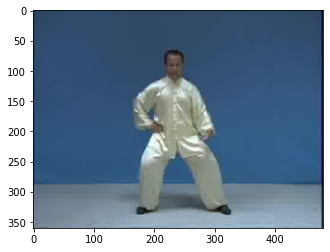

[[[  8.          8.       ]
  [ 77.333336    8.       ]
  [146.66667     8.       ]
  [216.          8.       ]
  [285.33334     8.       ]
  [354.6667      8.       ]
  [424.          8.       ]
  [493.33337     8.       ]
  [562.6667      8.       ]
  [632.          8.       ]
  [  8.         46.22222  ]
  [ 77.333336   46.22222  ]
  [146.66667    46.22222  ]
  [216.         46.22222  ]
  [285.33334    46.22222  ]
  [354.6667     46.22222  ]
  [424.         46.22222  ]
  [493.33337    46.22222  ]
  [562.6667     46.22222  ]
  [632.         46.22222  ]
  [  8.         84.44444  ]
  [ 77.333336   84.44444  ]
  [146.66667    84.44444  ]
  [216.         84.44444  ]
  [285.33334    84.44444  ]
  [354.6667     84.44444  ]
  [424.         84.44444  ]
  [493.33337    84.44444  ]
  [562.6667     84.44444  ]
  [632.         84.44444  ]
  [  8.        122.66667  ]
  [ 77.333336  122.66667  ]
  [146.66667   122.66667  ]
  [216.        122.66667  ]
  [285.33334   122.66667  ]
  [354.6667    122.6

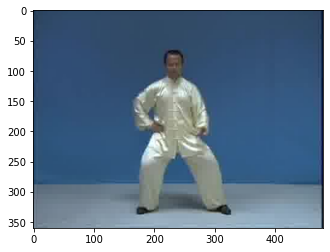

[[[  8.          8.       ]
  [ 77.333336    8.       ]
  [146.66667     8.       ]
  [216.          8.       ]
  [285.33334     8.       ]
  [354.6667      8.       ]
  [424.          8.       ]
  [493.33337     8.       ]
  [562.6667      8.       ]
  [632.          8.       ]
  [  8.         46.22222  ]
  [ 77.333336   46.22222  ]
  [146.66667    46.22222  ]
  [216.         46.22222  ]
  [285.33334    46.22222  ]
  [354.6667     46.22222  ]
  [424.         46.22222  ]
  [493.33337    46.22222  ]
  [562.6667     46.22222  ]
  [632.         46.22222  ]
  [  8.         84.44444  ]
  [ 77.333336   84.44444  ]
  [146.66667    84.44444  ]
  [216.         84.44444  ]
  [285.33334    84.44444  ]
  [354.6667     84.44444  ]
  [424.         84.44444  ]
  [493.33337    84.44444  ]
  [562.6667     84.44444  ]
  [632.         84.44444  ]
  [  8.        122.66667  ]
  [ 77.333336  122.66667  ]
  [146.66667   122.66667  ]
  [216.        122.66667  ]
  [285.33334   122.66667  ]
  [354.6667    122.6

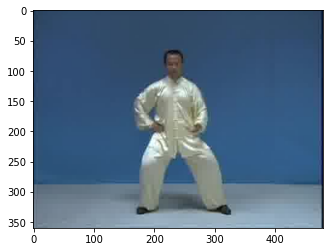

[[[  8.          8.       ]
  [ 77.333336    8.       ]
  [146.66667     8.       ]
  [216.          8.       ]
  [285.33334     8.       ]
  [354.6667      8.       ]
  [424.          8.       ]
  [493.33337     8.       ]
  [562.6667      8.       ]
  [632.          8.       ]
  [  8.         46.22222  ]
  [ 77.333336   46.22222  ]
  [146.66667    46.22222  ]
  [216.         46.22222  ]
  [285.33334    46.22222  ]
  [354.6667     46.22222  ]
  [424.         46.22222  ]
  [493.33337    46.22222  ]
  [562.6667     46.22222  ]
  [632.         46.22222  ]
  [  8.         84.44444  ]
  [ 77.333336   84.44444  ]
  [146.66667    84.44444  ]
  [216.         84.44444  ]
  [285.33334    84.44444  ]
  [354.6667     84.44444  ]
  [424.         84.44444  ]
  [493.33337    84.44444  ]
  [562.6667     84.44444  ]
  [632.         84.44444  ]
  [  8.        122.66667  ]
  [ 77.333336  122.66667  ]
  [146.66667   122.66667  ]
  [216.        122.66667  ]
  [285.33334   122.66667  ]
  [354.6667    122.6

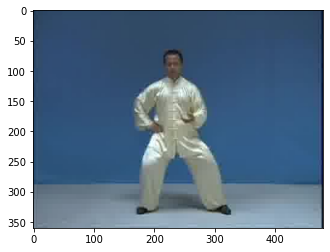

[[[  8.          8.       ]
  [ 77.333336    8.       ]
  [146.66667     8.       ]
  [216.          8.       ]
  [285.33334     8.       ]
  [354.6667      8.       ]
  [424.          8.       ]
  [493.33337     8.       ]
  [562.6667      8.       ]
  [632.          8.       ]
  [  8.         46.22222  ]
  [ 77.333336   46.22222  ]
  [146.66667    46.22222  ]
  [216.         46.22222  ]
  [285.33334    46.22222  ]
  [354.6667     46.22222  ]
  [424.         46.22222  ]
  [493.33337    46.22222  ]
  [562.6667     46.22222  ]
  [632.         46.22222  ]
  [  8.         84.44444  ]
  [ 77.333336   84.44444  ]
  [146.66667    84.44444  ]
  [216.         84.44444  ]
  [285.33334    84.44444  ]
  [354.6667     84.44444  ]
  [424.         84.44444  ]
  [493.33337    84.44444  ]
  [562.6667     84.44444  ]
  [632.         84.44444  ]
  [  8.        122.66667  ]
  [ 77.333336  122.66667  ]
  [146.66667   122.66667  ]
  [216.        122.66667  ]
  [285.33334   122.66667  ]
  [354.6667    122.6

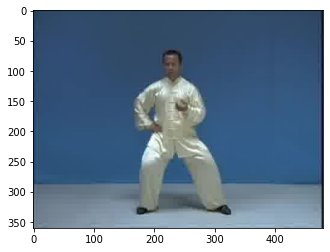

[[[  8.          8.       ]
  [ 77.333336    8.       ]
  [146.66667     8.       ]
  [216.          8.       ]
  [285.33334     8.       ]
  [354.6667      8.       ]
  [424.          8.       ]
  [493.33337     8.       ]
  [562.6667      8.       ]
  [632.          8.       ]
  [  8.         46.22222  ]
  [ 77.333336   46.22222  ]
  [146.66667    46.22222  ]
  [216.         46.22222  ]
  [285.33334    46.22222  ]
  [354.6667     46.22222  ]
  [424.         46.22222  ]
  [493.33337    46.22222  ]
  [562.6667     46.22222  ]
  [632.         46.22222  ]
  [  8.         84.44444  ]
  [ 77.333336   84.44444  ]
  [146.66667    84.44444  ]
  [216.         84.44444  ]
  [285.33334    84.44444  ]
  [354.6667     84.44444  ]
  [424.         84.44444  ]
  [493.33337    84.44444  ]
  [562.6667     84.44444  ]
  [632.         84.44444  ]
  [  8.        122.66667  ]
  [ 77.333336  122.66667  ]
  [146.66667   122.66667  ]
  [216.        122.66667  ]
  [285.33334   122.66667  ]
  [354.6667    122.6

In [66]:
from numpy import load
np.set_printoptions(threshold=sys.maxsize)
data = load('Tai chiRen Guang Yi - Chen Style Taiji silk reeling part II-Wh3AmDsdQtM.npz', allow_pickle=True)
lst = data.files
for item in lst:
  for x in range(len(item)):
    plt.imshow(data[item][x][0])
    plt.show()
    print(data[item][x][1])

In [ ]:
# zip all numpy files
# cp NumPy zip file into drive

In [56]:
x = np.random.randn(10, 3)
print(x)
x_split = np.split(x, 5, axis=0)
print(x_split)
np.concatenate(x_split[:1] + x_split[1:], axis=0)
x[-1]

[[-0.19265202 -1.16034241  0.56667005]
 [ 0.72274194  1.49247224  0.50849294]
 [ 0.06550223  1.28672026  0.2862726 ]
 [ 0.85893659 -0.4157535  -0.42443766]
 [ 1.1032692   0.34233048 -0.28891768]
 [ 0.17057637  0.20528025  0.23395913]
 [-0.93010834  0.11896288  0.34466525]
 [-1.45860967  2.55662548 -1.41979143]
 [ 0.74269002  0.03394718 -0.9873447 ]
 [ 0.58324264  0.47655027  1.7006449 ]]
[array([[-0.19265202, -1.16034241,  0.56667005],
       [ 0.72274194,  1.49247224,  0.50849294]]), array([[ 0.06550223,  1.28672026,  0.2862726 ],
       [ 0.85893659, -0.4157535 , -0.42443766]]), array([[ 1.1032692 ,  0.34233048, -0.28891768],
       [ 0.17057637,  0.20528025,  0.23395913]]), array([[-0.93010834,  0.11896288,  0.34466525],
       [-1.45860967,  2.55662548, -1.41979143]]), array([[ 0.74269002,  0.03394718, -0.9873447 ],
       [ 0.58324264,  0.47655027,  1.7006449 ]])]


array([0.58324264, 0.47655027, 1.7006449 ])